# Marginal Gaussian Process

### The Model

A Marginal Gaussian process jointly representing the data as a large probability distribution. This distribution, as we will see, turns out to a normal distribution in classical Bayesian approaches. Suppose we have some data $X, y$ using which we want to predict the distribution over some $y_*$ given new data $X_*$. We write this as:

$$P(y_* \mid X, y, X_*)$$

This distribution is known as the ***conditional*** distribution.

We can construct this joint density through the use of the following decomposition:

$$P(y_* \mid X, y, X_*) = \int{ P(y_* \mid X_*, \theta) P(\theta \mid X, y) }$$

where we represent all the parameters by $\theta$ and $P(\theta \mid X, y)$ is the posterior density given data and $P(y_* \mid X_*, \theta)$ is known as the ***marginal likelihood*** of the individual test point given the parameters.

The marginal likelihood of the model is assumed to be a gaussian with parameters:

$$P(y \mid X, \theta) = \mathcal{N}(m(X), K(X, X) + \delta(\epsilon))$$

where $m(\cdot)$ is the ***mean*** function and $K(\cdot)$ is the ***kernel*** function. The mean function evaluates a mean vector. The kernel function takes some parameters $\theta$ and evaluates the covariance between every pair of data points to output a covariance matrix. The $\delta(\cdot)$ is the kronecker delta function and $\epsilon$ is a small noise. The delta function adds a small noise corruption and is equivalent to adding noise distrbuted as $\mathcal{N}(0, \epsilon\mathrm{I})$.

This mean vector and the covariance matrix is then input to the multivariate normal distribution. This choice of using a normal distribution makes the integral in the conditional distribution analytical, hence, making it easy to infer a distrution over the test data for prediction and generation.

### Performing Inference

The conditional distrution can also be shown to be a normal distrbution with parameters:

$$P(y_* \mid X, y, X_*) = \mathcal{N}(\mu_{y_* \mid D}, \Sigma_{y_* \mid D})$$

where

$$
\begin{align*}
\mu_{y_* \mid D}    &= K_*^T \left( K + \epsilon\mathrm{I} \right)^{-1} y \\
\Sigma_{y_* \mid D} &= K_{**} - K_*^T \left( K + \epsilon\mathrm{I} \right)^{-1} K_* \\
K_*                 &= K(X, X_*) \\
K_{**}              &= K(X_*, X_*) \\
K                   &= K(X, X)
\end{align*}
$$

This distribution can be used to make predictions over the test data or generate predictive samples.

### References

- http://www.cs.cornell.edu/courses/cs4780/2017sp/lectures/lecturenote15.html
- http://inverseprobability.com/talks/notes/gaussian-processes.html

# MareginalGP Model

`MarginalGP` model is the implementation of the Marginal GP model in PyMC4. It contains `marginal_likelihood` and `conditional` method that does exactly as described in the previous section. Moreover, it also has methods `predict` and `predictt` to sample from the conditional distribution and to get point estimate ($\mu_{y_* \mid D}$) of the conditional distribution respectively.

Let's see each method in detail in following sections:

### `marginal_likelihood` method

First, we need to instantiate the model using a kernel function and (optionally) a mean function.

```python
from pymc4.gp import MarginalGP
from pymc4.gp.cov import ExpQuad

# Let's first instantiate a kernel
K = ExpQuad(length_scale = 1.)

# Now, we can instantiata the model
gp = MarginalGP(cov_fn = K)
```

Now, To get the ``marginal_likelihood`` of the MarginalGP over some data ``X`` (of shape `(n_samples, n_features)`) with labels ``y`` (of shape `(n_samples, )`), use:

```python
noise = 1e-2
y_ = gp.marginal_likelihood("y_", X, y, noise=noise)
```

You can also pass a covariance object as noise to the `marginal_likelihood`
method:
        
```python
# kronecker delta function with epsilon 1e-2
noise = WhiteNoise(1e-2)
y_ = gp.marginal_likelihood("y_", X, y, noise=noise)
```

If ``y`` is not the observed data, pass ``is_observed=False`` in the
        marginal likelihood method:

```python
y_ = gp.marginal_likelihood("y_", X, y, noise=noise, is_observed=False)
```

By default, some ``jitter`` is added to ensure Cholesky Decomposition passes.
        This behaviour can be turned off by passing ``jitter=0`` in the marginal
        likehood method:

```python
y_ = gp.marginal_likelihood("y_", X, y, noise=noise, jitter=0)
```

As ``noise`` behaves exactly as ``jitter``, it is recommended to set ``jitter=False``
        to avoid adding extra noise.

### `conditional` method

You can use conditional method to get the conditional distribution
        over the new data points. This distribution can be used to predict
        over the new data points:
        
```python
y_pred = gp.conditional("y_pred", Xnew, given={"X": X, "y": y, "noise": noise})
```

where `Xnew` are the test points (new data points) and `y_pred` is a multivariate normal distribution. `given` dictionary is optional when `marginal_likelihood` method has been called before.

```python
y_ = gp.marginal_likelihood("y_", X, y, noise=noise)
y_pred = gp.conditional("y_pred", Xnew) # no need to pass given
```

To add noise in the conditional distribution, use:

```python
y_pred = gp.conditional("y_pred", Xnew, pred_noise=True)
```

To avoid reparametrizing to the ``MvNormalCholesky`` distribution, use:

```python
y_pred = gp.conditional("y_pred", Xnew, reparametrize=False)
```

In [1]:
import sys
sys.path.append("../")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc4 as pm
from pymc4.gp import MarginalGP
from pymc4.gp.cov import Matern52, ExpQuad
np.random.seed(42)
tf.random.set_seed(42)

### Example 1 : Regression on Student-T distributed data

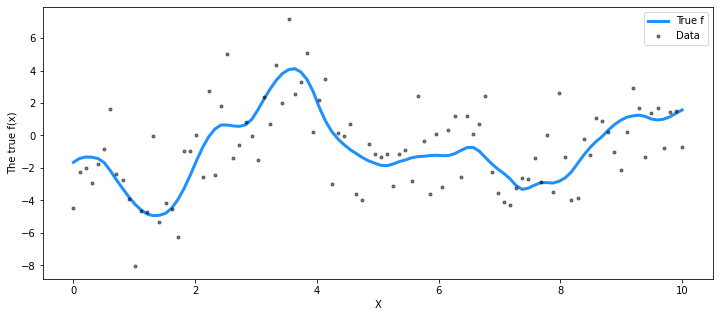

In [2]:
n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = np.array(1.0)
η_true = np.array(3.0)
cov_func = η_true**2 * Matern52(ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X), 
                                       cov_func(X, X) + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

In [3]:
@pm.model
def MarginalGPModel(X, y):
    ℓ = yield pm.Gamma("ℓ", np.array(2.), np.array(1.))
    η = yield pm.HalfCauchy("η", np.array(5.))

    cov = η**2 * Matern52(ℓ)
    gp = MarginalGP(cov_fn=cov)

    σ = yield pm.HalfCauchy("σ", np.array(5.))
    y_ = yield gp.marginal_likelihood("y", X=X, y=y, noise=σ, jitter=np.array(0))

In [4]:
model = MarginalGPModel(X, y)

In [5]:
advifit = pm.fit(model, method="fullrank_advi")

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_fn` definition.


In [6]:
trace = advifit[0].sample(1000)

In [7]:
ppc = pm.sample_posterior_predictive(model, trace, var_names=["MarginalGPModel/y"])

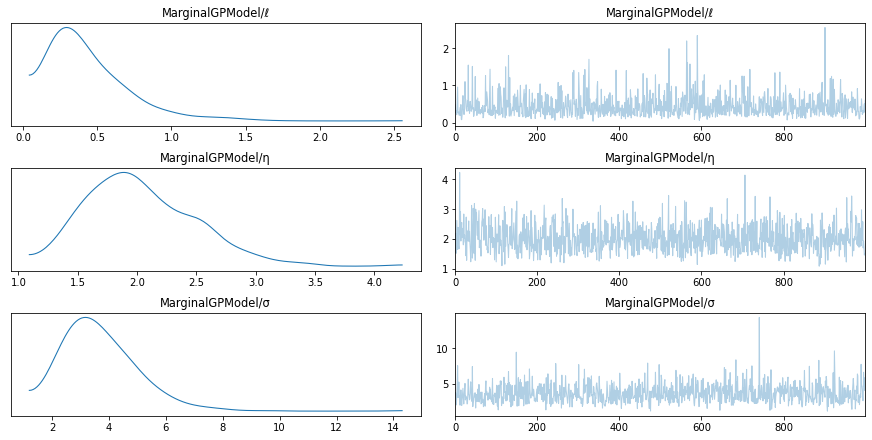

In [8]:
az.plot_trace(trace, var_names=["MarginalGPModel/ℓ", "MarginalGPModel/η", "MarginalGPModel/σ"]);

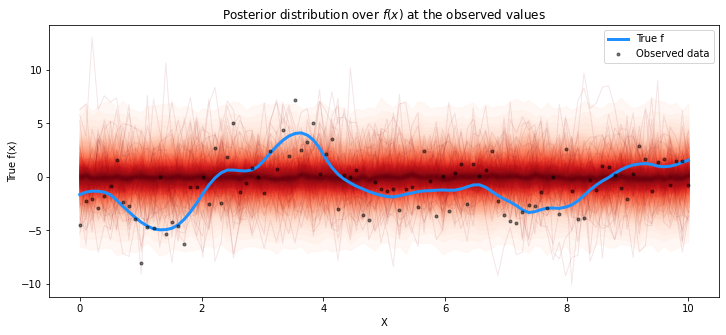

In [9]:
from pymc4.plots import plot_gp_dist

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, np.array(ppc.posterior_predictive["MarginalGPModel/y"])[0], X)

# plot the data and the true labels
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();